# get CE rate as a function of M_gw emitting

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
import pandas as pd
import numpy as np
import os
import sys
import glob
import time
import math
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FuncFormatter, MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from termcolor import colored
from COSMIClib import *
# parallelization stuff
from joblib import Parallel, delayed
import multiprocessing
import subprocess
import h5py

In [2]:
root = "/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/"
folders = sorted(glob.glob(root+"/qcrits*/"))
print(folders)
default_folder = glob.glob(root+"qcrits_clayes/")[0]
# print(default_folder)

['/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_0.0001/', '/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_0.1/', '/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_1/', '/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_1000/', '/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_2/', '/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_clayes/', '/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_clayes_Z0.002/', '/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_indipendent_dist/', '/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_inf/']


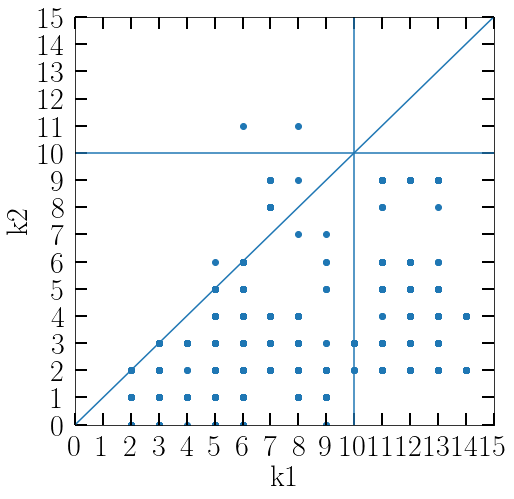

In [19]:
def typesMap(folder):
    fig = plt.figure(figsize=(15., 15.))
    gs = gridspec.GridSpec(2,2)
    gs.update(wspace=0,hspace=0)# top=1.1)
    ax = plt.subplot(gs[0])
    # read data
    h5frame = glob.glob(folder+"*.h5")[0]
    bpp =  pd.read_hdf(h5frame, key='bpp') # key evolutionary changes
    iCEinit = bpp.evol_type == 7 # evol_type == 7 means beginning of CE event   
    k1 = bpp.loc[iCEinit].kstar_1
    k2 = bpp.loc[iCEinit].kstar_2

    ax.scatter(k1, k2)
    ax.set_xlabel(r"k1",size=30)
    ax.set_ylabel(r"k2",size=30)
    ax.axvline(10,0,1)
    ax.axhline(10,0,1)
    ax.plot(np.linspace(0,15,2),np.linspace(0,15,2))
    ax.set_xlim(0,15)
    ax.set_ylim(0,15)

    ax.tick_params(axis='both', which='major', width=2, top="on", right="on", length=12, pad=10, labelsize=30, direction='in')
    ax.tick_params(axis='both', which='minor', width=2, top="on", right="on", length=6, pad=10, direction='in')

    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    # ax.xaxis.set_minor_locator(MultipleLocator(10))

    
# test
typesMap(default_folder)    

In [3]:
def getGWemittingM(bpp, index):
    # index are the indexes we want
    # get stellar types according to Hurley+2000
    k1 = bpp.loc[index].kstar_1
    k2 = bpp.loc[index].kstar_2   
    Mcore1 = bpp.loc[index].massc_1
    Mcore2 = bpp.loc[index].massc_2
    M1 = bpp.loc[index].mass_1
    M2 = bpp.loc[index].mass_2
    Mgw = np.zeros(len(M1)) # to be filled
    # print(len(k1),len(k2), len(Mcore1), len(Mcore2), len(M1), len(M2), len(Mgw))
    # if both MS
    ibothMS = (k1 <= 1) & (k2 <=1)
    Mgw[ibothMS] = M1[ibothMS]+M2[ibothMS]
    # consider CE where both stars are non-degenerate
    inondeg = (k1 <10) & (k2<10) & (not ibothMS)
    # donor 1
    idonor1 = inondeg & (k1-k2 > 0) #NB strictly >
    Mgw[idonor1] = Mcore1[idonor1]+M2[idonor1]
    # double core
    idc = inondeg & (k1-k2 == 0)
    Mgw[idc] = Mcore1[idc]+Mcore2[idc]
    # donor 2
    idonor2 = inondeg & (k1-k2 < 0)
    Mgw[idonor2] = Mcore2[idonor2]+M1[idonor2]
    # now deal with degenerate stars
    # 1 is degenerate but 2 isn't
    ideg1nondeg2 = (k1>=10)&(k2<10)
    Mgw[ideg1nondeg2] = Mcore2[ideg1nondeg2]+M1[ideg1nondeg2]
    # 2 degenerate but 1 not
    ideg2nondeg1 = (k1<10)&(k2>=10)
    Mgw[ideg2nondeg1] = Mcore1[ideg2nondeg1]+M2[ideg2nondeg1]
    # both degenerate -- should be rare
    ibothdeg = (k1>=10) & (k2>=10)
    Mgw[ibothdeg] = M1[ibothdeg]+M2[ibothdeg]
    ## sanity check:
    # all = np.array(idonor1,dtype=int)+np.array(idonor2,dtype=int)+np.array(idc,dtype=int)+np.array(ideg1nondeg2,dtype=int)+np.array(ideg2nondeg1,dtype=int)+np.array(ibothdeg,dtype=int)
    # print(min(all), max(all)) ## should both be 1
    #print(min(Mgw), max(Mgw))
    # Mgw = Mcore1 + M2
    return Mgw

# test
h5frame = glob.glob(default_folder+"*.h5")[0]
bpp =  pd.read_hdf(h5frame, key='bpp') # key evolutionary changes
iCEinit = bpp.evol_type == 7 # evol_type == 7 means beginning of CE event   
getGWemittingM(bpp, iCEinit)


NameError: name 'default_folder' is not defined

In [37]:
def getCErates_masscut(folder, SFR=3.5, Mcut = 10):
    # SFR is the assumed star formation rate in Msun/yr
    # folder contains the h5 frame output from cosmic-pop
    # Mcut the minimum GW emitting mass considered
    h5frame = glob.glob(folder+"*.h5")[0]
    bpp =  pd.read_hdf(h5frame, key='bpp') # key evolutionary changes
    total_mass = pd.read_hdf(h5frame, key='mass_stars')
    # total mass of the simulation
    Mtot = max(np.array(total_mass))[0]
    
    ## all CE events
    ## convert to astrophysical rate
    ## following https://cosmic-popsynth.github.io/docs/stable/fixedpop/index.html
    
    # get all CE event initiations
    iCEinit = bpp.evol_type == 7 # evol_type == 7 means beginning of CE event

    # select only a certain GW emitting mass
    Mgw = getGWemittingM(bpp, iCEinit)
    ## NB: Mgw has the length of iCEinit == True
    # print(len(Mgw),np.sum(iCEinit == 1),len(iCEinit))
    iMassive_enough = Mgw >= Mcut
    ## index = iCEinit * iMassive_enough
    index = iMassive_enough
    
    Nastro_CE = np.sum(index) # sum of all the CE events that are occurring
    Nastro_CE *= 1.0/Mtot # CE event occurring per unit mass of star formed [1/Msun]
    Nastro_CE *= SFR # [1/yr]

    ## only double core CE events
    # now lets get only the ones with a double core CE
    iCEdoublecore = (bpp.evol_type == 7) & ((bpp.kstar_1>1) & (bpp.kstar_2>1)) # CE initiation and both stars are post MS, so both have a core
    # print(np.sum(iCEdoublecore))

    Mgw = getGWemittingM(bpp, iCEdoublecore)
    iMassive_enough = Mgw >= Mcut
    # index_doublecore = iCEinit * iMassive_enough
    index_doublecore = iMassive_enough
    
    Nastro_CEdc = np.sum(index_doublecore) # sum of all the CE events that are occurring
    Nastro_CEdc *= 1.0/Mtot # CE event occurring per unit mass of star formed [1/Msun]
    Nastro_CEdc *= SFR # [1/yr]
    
    # print("number of double core (both post-MS) CE initiated per year:",Nastro_CEdc)
    # print("so every ~ %.0f"%float(1.0/Nastro_CEdc),"years a double core CE event starts in the Galaxy")
    # print("=============================================================================")
    return Nastro_CE, Nastro_CEdc

# Test
getCErates_masscut(default_folder)

(0.007074558337340456, 0.0026797569459622935)

In [5]:
def getCErates_SepinitCut(folder, SFR=3.5, SepinitCut=1000):
    h5frame = glob.glob(folder+"*.h5")[0]
    bpp =  pd.read_hdf(h5frame, key='bpp') # key evolutionary changes
    # print(bpp.columns)
    total_mass = pd.read_hdf(h5frame, key='mass_stars')
    Mtot = max(np.array(total_mass))[0]

    iCEinit = bpp.evol_type == 7 # evol_type == 7 means beginning of CE event   
    iCEdoublecore = (bpp.evol_type == 7) & ((bpp.kstar_1>1) & (bpp.kstar_2>1)) # CE initiation and both stars are post MS, so both have a core
    
    Sep_CE = bpp.loc[iCEinit].sep
    Sep_CE_dc = bpp.loc[iCEdoublecore].sep

    iCE = iCEinit*(Sep_CE >= SepinitCut)
    Nastro_CE = np.sum(iCE) # sum of all the CE events that are occurring
    Nastro_CE *= 1.0/Mtot # CE event occurring per unit mass of star formed [1/Msun]
    Nastro_CE *= SFR # [1/yr]

    iCE_dc = iCEdoublecore*(Sep_CE_dc >= SepinitCut)
    Nastro_CEdc = np.sum(iCE_dc) # sum of all the CE events that are occurring
    Nastro_CEdc *= 1.0/Mtot # CE event occurring per unit mass of star formed [1/Msun]
    Nastro_CEdc *= SFR # [1/yr]

    return Nastro_CE, Nastro_CEdc



In [6]:
def getCErates_SepFinalCut(folder, SFR=3.5, SepFinalCut=1000):
    h5frame = glob.glob(folder+"*.h5")[0]
    bpp =  pd.read_hdf(h5frame, key='bpp') # key evolutionary changes
    # print(bpp.columns)
    total_mass = pd.read_hdf(h5frame, key='mass_stars')
    Mtot = max(np.array(total_mass))[0]


    iCEFinal = bpp.evol_type == 8 # evol_type == 8 means end of a CE event
    iCEdoublecore = (bpp.evol_type == 8) & ((bpp.kstar_1>1) & (bpp.kstar_2>1)) # CE Finaliation and both stars are post MS, so both have a core
    
    Sep_CE = bpp.loc[iCEFinal].sep
    Sep_CE_dc = bpp.loc[iCEdoublecore].sep

    iCE = iCEFinal*(Sep_CE >= SepFinalCut)
    Nastro_CE = np.sum(iCE) # sum of all the CE events that are occurring
    Nastro_CE *= 1.0/Mtot # CE event occurring per unit mass of star formed [1/Msun]
    Nastro_CE *= SFR # [1/yr]

    iCE_dc = iCEdoublecore*(Sep_CE_dc >= SepFinalCut)
    Nastro_CEdc = np.sum(iCE_dc) # sum of all the CE events that are occurring
    Nastro_CEdc *= 1.0/Mtot # CE event occurring per unit mass of star formed [1/Msun]
    Nastro_CEdc *= SFR # [1/yr]

    return Nastro_CE, Nastro_CEdc


dealing with /mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_0.1/ #4477AA


dealing with /mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_1/ #44AAAA


dealing with /mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_2/ #AAAA44


dealing with /mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_clayes/ #AA7744


dealing with /mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_clayes_Z0.002/ #AA4455


dealing with /mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_indipendent_dist/ #AA4488


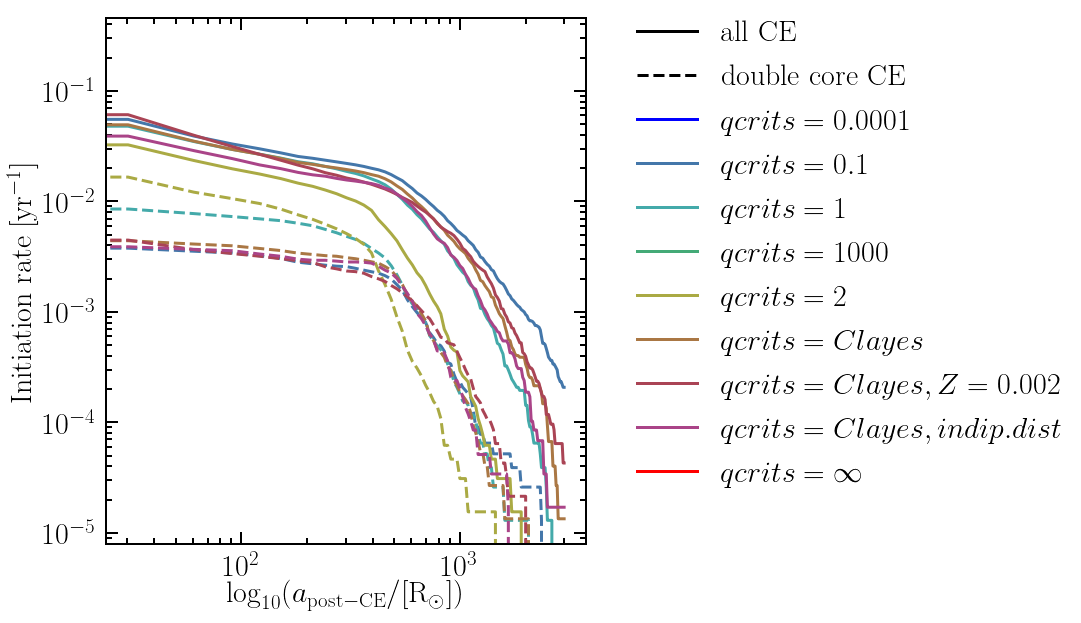

In [10]:
fig = plt.figure(figsize=(15., 15.))
gs = gridspec.GridSpec(2,2)
gs.update(wspace=0,hspace=0)# top=1.1)
ax = plt.subplot(gs[0])

Sepcuts = np.linspace(0,3000, 100)
folders = ["/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_0.1/", "/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_1/", "/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_2/", "/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_clayes/","/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_clayes_Z0.002/", "/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_indipendent_dist/"]
colors = ['#4477AA',
          '#44AAAA',
          '#AAAA44',
          '#AA7744',
          '#AA4455',
          '#AA4488']

for folder in folders:
    c = colors[folders.index(folder)]
    print("dealing with", folder, c)
    allCErate = []
    doublecoreCErate = []
    for Sepcut in Sepcuts:
        Rall, Rdoublecore = getCErates_SepFinalCut(folder, SFR=3.5, SepFinalCut=Sepcut)    
        allCErate.append(Rall)
        doublecoreCErate.append(Rdoublecore)
    #
    ax.plot(Sepcuts, allCErate, lw=3,c=c,ls='-')
    ax.plot(Sepcuts, doublecoreCErate, lw=3,c=c,ls='--')

ax.plot(np.nan, np.nan, lw=3,ls='-', c='k', label=r"all CE")
ax.plot(np.nan, np.nan, lw=3,ls='--',c='k', label=r"double core CE")
ax.plot(np.nan, np.nan, lw=3,ls='-', c='b', label=r"$qcrits=0.0001$")
ax.plot(np.nan, np.nan, lw=3,ls='-', c='#4477AA', label=r"$qcrits=0.1$")
ax.plot(np.nan, np.nan, lw=3,ls='-', c='#44AAAA', label=r"$qcrits=1$")
ax.plot(np.nan, np.nan, lw=3,ls='-', c='#44AA77', label=r"$qcrits=1000$")
ax.plot(np.nan, np.nan, lw=3,ls='-', c='#AAAA44', label=r"$qcrits=2$")
ax.plot(np.nan, np.nan, lw=3,ls='-', c='#AA7744', label=r"$qcrits=Clayes$")
ax.plot(np.nan, np.nan, lw=3,ls='-', c='#AA4455', label=r"$qcrits=Clayes, Z=0.002$")
ax.plot(np.nan, np.nan, lw=3,ls='-', c='#AA4488', label=r"$qcrits=Clayes, indip. dist$")
ax.plot(np.nan, np.nan, lw=3,ls='-', c='r', label=r"$qcrits=\infty$")

l=ax.legend(fontsize=30, loc="best", bbox_to_anchor=(1.05,1.05))
l.draw_frame(False)

# ax.set_xlabel(r"$\log_{10}(P_\mathrm{pre-CE}/ \mathrm{[days]})$", fontsize=30)
ax.set_xlabel(r"$\log_{10}(a_\mathrm{post-CE}/ \mathrm{[R_\odot]})$", fontsize=30)
ax.set_ylabel(r"$\mathrm{Initiation\ rate} \ [\mathrm{yr^{-1}}]$", fontsize=30)

ax.tick_params(axis='both', which='major', width=2, top="on", right="on", length=12, pad=10, labelsize=30, direction='in')
ax.tick_params(axis='both', which='minor', width=2, top="on", right="on", length=6, pad=10, direction='in')
# ax.xaxis.set_major_locator(MultipleLocator(20))
# ax.xaxis.set_minor_locator(MultipleLocator(10))
# ax.yaxis.set_major_locator(MultipleLocator(0.1))
# ax.yaxis.set_minor_locator(MultipleLocator(0.05))
# ax.set_xlim(1e-8,3000)
ax.set_yscale('log')
ax.set_xscale('log')
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
plt.tight_layout()
plt.savefig("/mnt/home/mrenzo/TMP/CE_rate_func_post-CEsep.pdf")

dealing with /mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_0.1/ #4477AA


dealing with /mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_1/ #44AAAA


dealing with /mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_2/ #AAAA44


dealing with /mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_clayes/ #AA7744


dealing with /mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_clayes_Z0.002/ #AA4455


dealing with /mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_indipendent_dist/ #AA4488


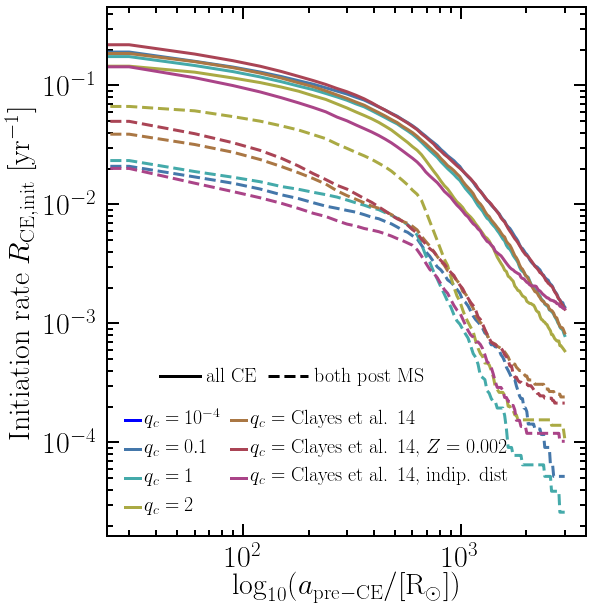

In [67]:
fig = plt.figure(figsize=(15., 15.))
gs = gridspec.GridSpec(2,2)
gs.update(wspace=0,hspace=0)# top=1.1)
ax = plt.subplot(gs[0])

Sepcuts = np.linspace(0,3000,101)

folders = ["/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_0.1/",
           "/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_1/",
           "/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_2/",
           "/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_clayes/",
           "/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_clayes_Z0.002/",
           "/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_indipendent_dist/"]
colors = ['#4477AA', '#44AAAA', '#AAAA44', '#AA7744', '#AA4455',
'#AA4488']

for folder in folders:
    c = colors[folders.index(folder)]
    print("dealing with", folder, c)
    allCErate = []
    doublecoreCErate = []
    for Sepcut in Sepcuts:
        Rall, Rdoublecore = getCErates_SepinitCut(folder, SFR=3.5, SepinitCut=Sepcut)    
        allCErate.append(Rall)
        doublecoreCErate.append(Rdoublecore)
    #
    ax.plot(Sepcuts, allCErate, lw=3,c=c,ls='-')
    ax.plot(Sepcuts, doublecoreCErate, lw=3,c=c,ls='--')


ax.plot(np.nan, np.nan, lw=3,ls='-', c='b', label=r"$q_c=10^{-4}$")
ax.plot(np.nan, np.nan, lw=3,ls='-', c='#4477AA', label=r"$q_c=0.1$")
ax.plot(np.nan, np.nan, lw=3,ls='-', c='#44AAAA', label=r"$q_c=1$")
# ax.plot(np.nan, np.nan, lw=3,ls='-', c='#44AA77', label=r"$qcrits=1000$")
ax.plot(np.nan, np.nan, lw=3,ls='-', c='#AAAA44', label=r"$q_c=2$")
ax.plot(np.nan, np.nan, lw=3,ls='-', c='#AA7744', label=r"$q_c=$ Clayes et al. 14")
ax.plot(np.nan, np.nan, lw=3,ls='-', c='#AA4455', label=r"$q_c=$ Clayes et al. 14, $Z=0.002$")
ax.plot(np.nan, np.nan, lw=3,ls='-', c='#AA4488', label=r"$q_c=$ Clayes et al. 14, indip. dist")
# ax.plot(np.nan, np.nan, lw=3,ls='-', c='r', label=r"$qcrits=\infty$")
        

l=ax.legend(fontsize=20, loc="lower left", handletextpad=0.2, handlelength=0.75, ncol=2, columnspacing=0.5) #bbox_to_anchor=(1.05,1.05))
l.draw_frame(False)

p1, = ax.plot(np.nan, np.nan, lw=3,ls='-', c='k', label=r"all CE")
p2, = ax.plot(np.nan, np.nan, lw=3,ls='--',c='k', label=r"both post MS")


l2=ax.legend([p1,p2],[r"all CE",r"both post MS"], fontsize=20,
             loc="center right", handletextpad=0.3, ncol=2,
             columnspacing=0.6, bbox_to_anchor=(0.7,0.3))
l2.draw_frame(False)

ax.add_artist(l)

# ax.set_xlabel(r"$\log_{10}(P_\mathrm{pre-CE}/ \mathrm{[days]})$", fontsize=30)
ax.set_xlabel(r"$\log_{10}(a_\mathrm{pre-CE}/ \mathrm{[R_\odot]})$", fontsize=30)
ax.set_ylabel(r"$\mathrm{Initiation\ rate}\ R_\mathrm{CE,init} \ [\mathrm{yr^{-1}}]$", fontsize=30)

ax.tick_params(axis='both', which='major', width=2, top="on", right="on", length=12, pad=10, labelsize=30, direction='in')
ax.tick_params(axis='both', which='minor', width=2, top="on", right="on", length=6, pad=10, direction='in')
# ax.xaxis.set_major_locator(MultipleLocator(20))
# ax.xaxis.set_minor_locator(MultipleLocator(10))
# ax.yaxis.set_major_locator(MultipleLocator(0.1))
# ax.yaxis.set_minor_locator(MultipleLocator(0.05))
# ax.set_xlim(xmin=1e-50,xmax=3000)
ax.set_yscale('log')
ax.set_xscale('log')
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
plt.tight_layout()
plt.savefig("/mnt/home/mrenzo/TMP/CE_rate_func_pre-CEsep.pdf", bbox_inches="tight")

dealing with /mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_0.1/ #4477AA


dealing with /mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_1/ #44AAAA


dealing with /mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_2/ #AAAA44


dealing with /mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_clayes/ #AA7744


dealing with /mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_clayes_Z0.002/ #AA4455


dealing with /mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_indipendent_dist/ #AA4488


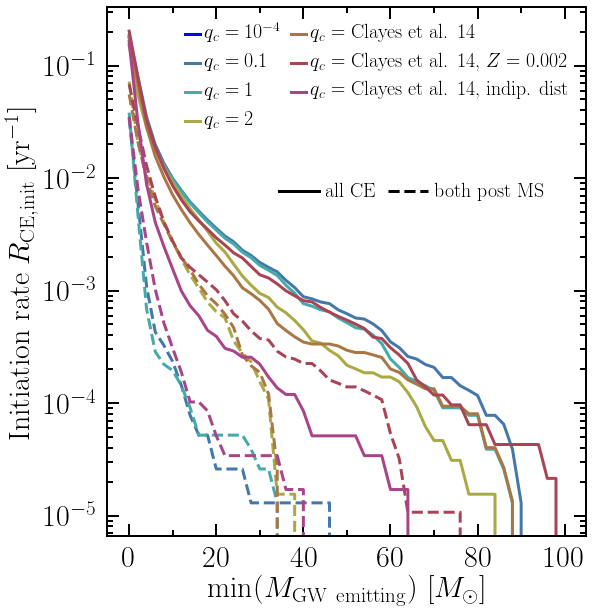

In [68]:
fig = plt.figure(figsize=(15., 15.))
gs = gridspec.GridSpec(2,2)
gs.update(wspace=0,hspace=0)# top=1.1)
ax = plt.subplot(gs[0])

Mcuts  = np.linspace(0,100,51)
###
# folder = default_folder
###
# for all folders
# colors = ["b","#4477AA","#44AAAA","#44AA77","#AAAA44","#AA7744","#AA4455","#AA4488",'r','m']
folders = ["/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_0.1/",
           "/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_1/",
           "/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_2/",
           "/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_clayes/",
           "/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_clayes_Z0.002/",
           "/mnt/home/mrenzo/RUNS/CE_GW/CE_pop_synth/COSMIC/qcrits_indipendent_dist/"]
colors = ['#4477AA', '#44AAAA', '#AAAA44', '#AA7744', '#AA4455',
'#AA4488']

for folder in folders:
    c = colors[folders.index(folder)]
    print("dealing with", folder, c)
    allCErate = []
    doublecoreCErate = []
    for Mcut in Mcuts:
        Rall, Rdoublecore = getCErates_masscut(folder, SFR=3.5, Mcut=Mcut)    
        allCErate.append(Rall)
        doublecoreCErate.append(Rdoublecore)
    #
    ax.plot(Mcuts, allCErate, lw=3,c=c,ls='-')
    ax.plot(Mcuts, doublecoreCErate, lw=3,c=c,ls='--')

ax.plot(np.nan, np.nan, lw=3,ls='-', c='b', label=r"$q_c=10^{-4}$")
ax.plot(np.nan, np.nan, lw=3,ls='-', c='#4477AA', label=r"$q_c=0.1$")
ax.plot(np.nan, np.nan, lw=3,ls='-', c='#44AAAA', label=r"$q_c=1$")
# ax.plot(np.nan, np.nan, lw=3,ls='-', c='#44AA77', label=r"$qcrits=1000$")
ax.plot(np.nan, np.nan, lw=3,ls='-', c='#AAAA44', label=r"$q_c=2$")
ax.plot(np.nan, np.nan, lw=3,ls='-', c='#AA7744', label=r"$q_c=$ Clayes et al. 14")
ax.plot(np.nan, np.nan, lw=3,ls='-', c='#AA4455', label=r"$q_c=$ Clayes et al. 14, $Z=0.002$")
ax.plot(np.nan, np.nan, lw=3,ls='-', c='#AA4488', label=r"$q_c=$ Clayes et al. 14, indip. dist")
# ax.plot(np.nan, np.nan, lw=3,ls='-', c='r', label=r"$qcrits=\infty$")
        

l=ax.legend(fontsize=20, loc="upper right", handletextpad=0.2, handlelength=0.75, ncol=2, columnspacing=0.5) #bbox_to_anchor=(1.05,1.05))
l.draw_frame(False)

p1, = ax.plot(np.nan, np.nan, lw=3,ls='-', c='k', label=r"all CE")
p2, = ax.plot(np.nan, np.nan, lw=3,ls='--',c='k', label=r"both post MS")


l2=ax.legend([p1,p2],[r"all CE",r"both post MS"], fontsize=20,
             loc="center right", handletextpad=0.3, ncol=2,
             columnspacing=0.6, bbox_to_anchor=(0.95,0.65))
l2.draw_frame(False)

ax.add_artist(l)

ax.set_xlabel(r"$\min(M_\mathrm{GW\ emitting}) \ [M_\odot]$", fontsize=30)
ax.set_ylabel(r"$\mathrm{Initiation\ rate}\  R_\mathrm{CE,init} \ [\mathrm{yr^{-1}}]$", fontsize=30)

ax.tick_params(axis='both', which='major', width=2, top="on", right="on", length=12, pad=10, labelsize=30, direction='in')
ax.tick_params(axis='both', which='minor', width=2, top="on", right="on", length=6, pad=10, direction='in')
ax.xaxis.set_major_locator(MultipleLocator(20))
ax.xaxis.set_minor_locator(MultipleLocator(10))
# ax.yaxis.set_major_locator(MultipleLocator(0.1))
# ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.set_yscale('log')
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
plt.tight_layout()
plt.savefig("/mnt/home/mrenzo/TMP/CE_rate_Mgw_subset.pdf", bbox_inches="tight")
plt.savefig("/mnt/home/mrenzo/TMP/CE_rate_Mgw_subset.png")